# This notebook shows data aggregation, feature engineering and how a decision tree model was implemented to predict the stock after earnings call

In [1]:
import numpy as np
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
import urllib.request
import csv
import time 
from random import randint
from datetime import datetime, timedelta
import csv
import glob
import re
import string
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import pandas_datareader as pdr
import Load_MasterDictionary as LM
import pickle
import os
MASTER_DICTIONARY_FILE = r'LoughranMcDonald_MasterDictionary_2014.csv'
lm_dictionary = LM.load_masterdictionary(MASTER_DICTIONARY_FILE, True)


 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2014.csv
  85,131 words loaded in master_dictionary.



In [2]:
#compute stock price and volatility change
#inputs: time stamp of earnings call, company ticker, number of days after and before call
#outputs: price and volatility changes
def compute_stock_prop(call_time,ticker,time_window):
    start_time = call_time - timedelta(days = time_window[0] + 5)#add extra days to account for weekend 
    end_time = call_time + timedelta(days = time_window[1] + 5) 
    stock_data = pdr.get_data_yahoo(ticker,start = start_time,end = end_time).reset_index()
    if len(stock_data) < 6:
        return None
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    
    #split into before and after earnings call
    stock_before = stock_data[stock_data['Date'] <= call_time]['Adj Close']
    stock_after = stock_data[stock_data['Date'] > call_time]['Adj Close']
    stock_before = stock_before[-time_window[0]:]
    stock_after = stock_after[0:time_window[1]]
    
    #compute stock price and volatitiy change
    price_change  = (stock_after.mean() - stock_before.mean())/stock_before.mean()
    vol_before = stock_before.std()*np.sqrt(len(stock_before))
    vol_after = stock_after.std()*np.sqrt(len(stock_after))
    vol_change = (vol_after - vol_before)/vol_before
    
    return price_change,vol_change

In [3]:
#extract featurs from doc using Loughran and McDonald Dictionary
def feature_extraction(doc):
    
    vdictionary = {}
    _odata = [0] * 17
    total_syllables = 0
    word_length = 0
    
    doc = doc.upper()
    tokens = re.findall('\w+', doc)  # Note that \w+ splits hyphenated words
    for token in tokens:
        if not token.isdigit() and len(token) > 1 and token in lm_dictionary:
            _odata[2] += 1  # word count
            word_length += len(token)
            if token not in vdictionary:
                vdictionary[token] = 1
            if lm_dictionary[token].positive: _odata[3] += 1
            if lm_dictionary[token].negative: _odata[4] += 1
            if lm_dictionary[token].uncertainty: _odata[5] += 1
            if lm_dictionary[token].litigious: _odata[6] += 1
            if lm_dictionary[token].weak_modal: _odata[7] += 1
            if lm_dictionary[token].moderate_modal: _odata[8] += 1
            if lm_dictionary[token].strong_modal: _odata[9] += 1
            if lm_dictionary[token].constraining: _odata[10] += 1
            total_syllables += lm_dictionary[token].syllables

    _odata[11] = len(re.findall('[A-Z]', doc))
    _odata[12] = len(re.findall('[0-9]', doc))
    # drop punctuation within numbers for number count
    doc = re.sub('(?!=[0-9])(\.|,)(?=[0-9])', '', doc)
    doc = doc.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    _odata[13] = len(re.findall(r'\b[-+\(]?[$€£]?[-+(]?\d+\)?\b', doc))
    _odata[14] = total_syllables / _odata[2]
    _odata[15] = word_length / _odata[2]
    _odata[16] = len(vdictionary) #number of unqiue words
    
    # Convert counts to %
    for i in range(3, 10 + 1):
        _odata[i] = (_odata[i] / _odata[2]) * 100
    # Vocabulary
        
    return _odata

In [4]:
#split one transcript into intro and Q&A
#compute the tone for both parts 
def parse_one_call_transcript(doc):
    doc = doc.upper()
    div = re.findall('QUESTION.{0,2}AND.{0,2}ANSWER.{0,10}\n|QUESTION.{0,2}&.{0,2}ANSWER.{0,10}\n',doc)
    if len(div) == 0:
        div = re.findall('QUESTION.*AND.ANSWER.{0,10}OPERATOR',doc)
    if len(div) == 0:
        div = re.findall('Q&A.{0,8}',doc)
    
    sections = doc.split(div[0])
    intro = sections[0]
    qna = sections[1]
    #compute linguistic characteristics using L and McDonauld dictionary 
    odata_intro = feature_extraction(intro)
    odata_qna = feature_extraction(qna)
    #tone = positive sentiment - negative sentiment
    tone_intro = odata_intro[3] - odata_intro[4]
    tone_qna = odata_qna[3] - odata_qna[4]
    #compute abnormal tone which is difference btw introduction tone and q&a tone
    tone_ab = tone_intro - tone_qna
    
    return tone_intro,tone_qna, tone_ab

In [5]:
# merge earnings call features with stock info for one company
def one_company_earnings_stock(company_name,time_window):
    ticker_list = {"Apple":"AAPL","Amazon":"AMZN","Twitter":"TWTR","Microsoft":"MSFT","IBM":"IBM",
                  "Facebook":"FB","Ebay":"EBAY","Google":"GOOG","Oracle":"ORCL","Intel":"INTC"}
    ticker = ticker_list[company_name]
    #load earnings call csv data
    path = os.getcwd()
    path = path[:-3]
    path = path + 'data/'
    earnings_txt = pd.read_csv(path + company_name + '_earnings_call.csv')
    
    # offset 12 hours
    # because (1) UTC is 4 or 5 hours ahead ET (2) the transcript could be posted the next morning 
    # if the call was at late evening. 
    time_earnings = pd.to_datetime(earnings_txt['time']) - timedelta(days=0.5)
    time_earnings = pd.to_datetime(time_earnings.apply(datetime.date))
    
    #extract tones
    tones = earnings_txt['full_text'].apply(parse_one_call_transcript)
    tone_intro = []
    tone_qna = []
    tone_ab = []
    for tone in tones:
        tone_intro.append(tone[0])
        tone_qna.append(tone[1])
        tone_ab.append(tone[2])
    
    earnings_stock = pd.DataFrame(time_earnings,columns = ['time'])
    earnings_stock['company'] = ticker
    earnings_stock['tone_intro'] = tone_intro
    earnings_stock['tone_qna'] = tone_qna
    earnings_stock['tone_ab'] = tone_ab
    
    #compute stock change
    stock_change = earnings_stock['time'].apply(compute_stock_prop,args = (ticker,time_window))
    
    price_change = []
    vola_change = []
    for change in stock_change:
        price_change.append(change[0])
        vola_change.append(change[1])
    
    earnings_stock['price_change'] = price_change
    earnings_stock['vola_change'] = vola_change   
        
    return earnings_stock




In [6]:
earnings_stock_apple = one_company_earnings_stock("Apple",[10,10])
earnings_stock_apple.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-02-01,AAPL,2.150873,0.374625,1.776247,-0.056756,0.286354
1,2018-05-01,AAPL,2.279202,0.935270,1.343933,0.109138,-0.027828
2,2018-07-31,AAPL,2.106742,0.402253,1.704489,0.082873,0.471192
3,2018-11-01,AAPL,2.369668,0.630252,1.739416,-0.080730,1.200596
4,2017-01-31,AAPL,2.786710,1.045053,1.741656,0.088377,1.458112


In [7]:
earnings_stock_google = one_company_earnings_stock("Google",[10,10])
earnings_stock_google.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,GOOG,1.778305,1.191620,0.586684,-0.033791,0.173274
1,2018-07-23,GOOG,1.868101,1.415094,0.453006,0.043541,0.082779
2,2018-04-23,GOOG,2.259887,1.182772,1.077115,-0.019830,-0.475137
3,2018-02-01,GOOG,2.312139,0.718798,1.593341,-0.090228,1.673856
4,2017-10-26,GOOG,1.880141,1.122083,0.758058,0.045064,-0.238424


In [8]:
earnings_stock_facebook = one_company_earnings_stock("Facebook",[10,10])
earnings_stock_facebook.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-30,FB,1.259876,1.160578,0.099298,-0.018333,-0.303639
1,2018-07-25,FB,1.351351,1.034956,0.316395,-0.155410,0.605153
2,2018-04-25,FB,1.471490,0.673092,0.798398,0.067980,0.035802
3,2018-01-31,FB,1.247554,0.897505,0.350049,-0.028465,1.197812
4,2017-11-01,FB,1.056803,0.393627,0.663176,0.020555,-0.821518


In [9]:
earnings_stock_twitter = one_company_earnings_stock("Twitter",[10,10])
earnings_stock_twitter.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,TWTR,0.257290,1.332659,-1.075369,0.166283,-0.214468
1,2018-07-27,TWTR,0.401204,1.114674,-0.713470,-0.245416,-0.834133
2,2018-04-25,TWTR,0.849858,1.676758,-0.826900,0.010407,-0.280025
3,2018-02-08,TWTR,1.580460,1.659429,-0.078970,0.252142,-0.432899
4,2017-10-26,TWTR,2.311436,1.406719,0.904716,0.117179,-0.155694


In [10]:
earnings_stock_ibm = one_company_earnings_stock("IBM",[10,10])
earnings_stock_ibm.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2019-01-22,IBM,1.225337,0.636943,0.588395,0.103278,-0.198814
1,2018-10-16,IBM,1.412503,0.649892,0.762612,-0.130027,0.177913
2,2018-07-18,IBM,1.325869,0.888287,0.437583,0.011290,-0.028287
3,2018-04-17,IBM,1.653294,0.781250,0.872044,-0.060312,-0.571390
4,2018-01-18,IBM,1.229508,1.085973,0.143535,0.000784,-0.233055


In [11]:
earnings_stock_amazon = one_company_earnings_stock("Amazon",[10,10])
earnings_stock_amazon.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,AMZN,-1.558442,0.694611,-2.253052,-0.074304,0.683891
1,2018-07-26,AMZN,-1.538462,1.487955,-3.026416,0.003950,1.150113
2,2018-04-26,AMZN,-1.530612,0.680581,-2.211193,0.060818,-0.624602
3,2018-02-01,AMZN,-0.854701,1.145931,-2.000632,0.019169,-0.149928
4,2017-10-26,AMZN,-1.530612,0.543725,-2.074337,0.127623,-0.182551


In [12]:
earnings_stock_microsoft = one_company_earnings_stock("Microsoft",[10,10])
earnings_stock_microsoft.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-24,MSFT,1.996008,1.189532,0.806476,-0.012089,-0.080742
1,2018-07-19,MSFT,2.227656,0.762281,1.465374,0.036852,-0.040369
2,2018-04-26,MSFT,2.286432,0.477281,1.809151,0.008510,0.005038
3,2018-01-31,MSFT,1.636541,0.693202,0.943339,-0.027205,0.540354
4,2017-10-26,MSFT,1.602347,0.814664,0.787683,0.073516,-0.219504


In [13]:
earnings_stock_ebay = one_company_earnings_stock("Ebay",[10,10])

In [14]:
earnings_stock_oracle = one_company_earnings_stock("Oracle",[10,10])
earnings_stock_oracle.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-12-17,ORCL,1.790634,0.515287,1.275347,-0.045176,-0.125360
1,2018-09-17,ORCL,0.899621,0.120409,0.779212,0.047221,0.659319
2,2018-06-19,ORCL,0.738151,0.030713,0.707438,-0.071300,-0.309686
3,2018-03-19,ORCL,0.174622,-0.155867,0.330489,-0.125251,0.836269
4,2017-12-14,ORCL,0.454545,0.366379,0.088166,-0.035775,-0.648074


In [15]:
earnings_stock_intel = one_company_earnings_stock("Intel",[10,10])

In [16]:
earnings_stock = pd.concat([earnings_stock_apple,earnings_stock_amazon,earnings_stock_microsoft,
                           earnings_stock_google,earnings_stock_facebook,earnings_stock_twitter,
                           earnings_stock_ibm,earnings_stock_ebay,earnings_stock_oracle,earnings_stock_intel])

In [17]:
def plot_senti_vs_stock(earnings_stock,company_name):
    fig,axs = plt.subplots(2,2,figsize = (10,8),constrained_layout=True)
    fig.suptitle('stock change around the call VS tone (' +company_name + ')',fontsize = 20)

    axs[0,0].plot(earnings_stock['tone_intro'],earnings_stock['price_change']*100,'r*')
    axs[0,0].tick_params('tone', colors='r')
    
    axs[0,0].set_ylabel('price change (%)', color='b',fontsize = 20)
    
    axs[0,1].plot(earnings_stock['tone_ab'],earnings_stock['price_change']*100,'b*')
    #axs[0,1].set_xlabel('tone',fontsize = 20)
    # Make the y-axis label, ticks and tick labels match the line color.
    #axs[0,1].yaxis.set_label_position("right")
    #axs[0,1].set_ylabel('price change (%)', color='b',fontsize = 20)
    axs[0,1].tick_params('tone', colors='b')
    
    
    axs[1,0].plot(earnings_stock['tone_intro'],earnings_stock['vola_change']*100,'r*')
    axs[1,0].tick_params('introduction tone', colors='r')
    axs[1,0].set_ylabel('vola change (%)', color='b',fontsize = 20)
    axs[1,0].set_xlabel('introduction tone',fontsize = 20)
    
    
    axs[1,1].plot(earnings_stock['tone_ab'],earnings_stock['vola_change']*100,'b*')
    axs[1,1].tick_params('abnormal tone', colors='b')
    #axs[1,1].set_ylabel('vola change (%)', color='b',fontsize = 20)
    axs[1,1].set_xlabel('abnormal tone',fontsize = 20)
    
    
    plt.show()
    
    #fig, ax2 = plt.subplots(1,facecolor='white', edgecolor='white',figsize=(6, 4))
    

In [18]:
#load earnings surprise data
def load_eps(company_name):
    path = os.getcwd()
    path = path[:-3]
    path = path + 'data/'
    eps_data = pd.read_csv(path + company_name + '_eps.csv',sep = '\t',names = ['time','eps'])
    eps_data['time'] = pd.to_datetime(eps_data['time'])
    eps_data['eps'] = eps_data['eps'].str.replace('%','').apply(float)
    return eps_data


In [19]:
#merge earnings call with earnings surprise data into one dataframe for each company
eps = load_eps('Twitter')
data_twitter = eps.merge(earnings_stock_twitter, on = 'time')
eps = load_eps('Facebook')
data_facebook = eps.merge(earnings_stock_facebook, on = 'time')
eps = load_eps('Apple')
data_apple = eps.merge(earnings_stock_apple, on = 'time')
eps = load_eps('Amazon')
data_amazon = eps.merge(earnings_stock_amazon, on = 'time')
eps = load_eps('Google')
data_google = eps.merge(earnings_stock_google, on = 'time')
eps = load_eps('Microsoft')
data_microsoft = eps.merge(earnings_stock_microsoft, on = 'time')
eps = load_eps('Ebay')
data_ebay = eps.merge(earnings_stock_ebay, on = 'time')
eps = load_eps('IBM')
data_ibm = eps.merge(earnings_stock_ibm, on = 'time')
eps = load_eps('Oracle')
data_oracle = eps.merge(earnings_stock_oracle, on = 'time')
eps = load_eps('Intel')
data_intel = eps.merge(earnings_stock_intel, on = 'time')

In [20]:
data_all = pd.concat([data_apple,data_amazon,data_microsoft,
                           data_google,data_facebook,data_twitter,
                           data_ibm,data_ebay,data_oracle,data_intel])

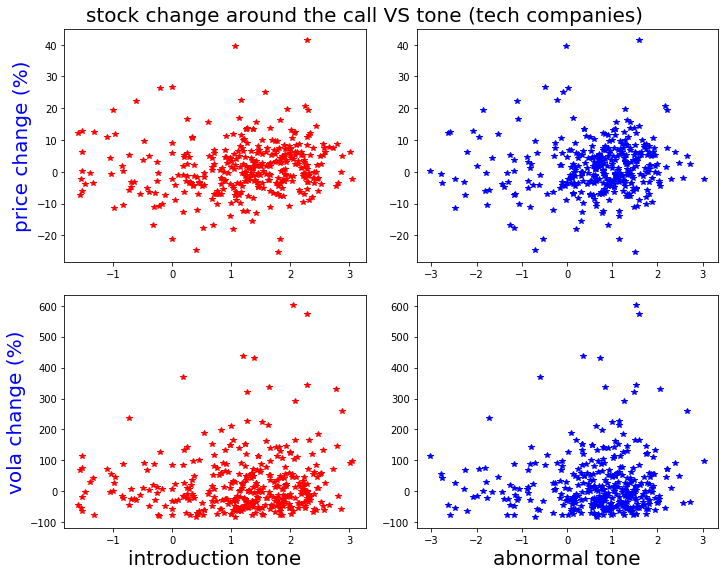

In [21]:
plot_senti_vs_stock(data_all,"tech companies")

In [22]:
len(data_all)

363

In [23]:
len(earnings_stock)

485

# implement decision tree regressor 

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz  
from sklearn.model_selection import KFold

In [25]:
X = data_all[['eps','tone_ab']]
y = data_all[['price_change','vola_change']]

In [26]:
def make_model(X,y):
    kf = KFold(n_splits = 14,shuffle = True)
    best_test_score = [float('-inf')]
    best_train_score = [float('-inf')]
    for train_index,test_index in kf.split(X):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]
        regressor = DecisionTreeRegressor(max_depth = 8)
        regressor.fit(X_train, y_train)
        test_score = regressor.score(X_test,y_test)
        train_score = regressor.score(X_train,y_train)
        if test_score > best_test_score:
            best_test_score = test_score
            best_train_score = train_score
            best_model = regressor
    return best_model,best_test_score,best_train_score    
    

In [27]:
#repeat multiple time until best model shows up
model,best_test_score,best_train_score = make_model(X,y)
print('best test score :' + str(best_test_score))
print('best train score :' + str(best_train_score))

best test score :0.1818859978262087
best train score :0.5923416932172407


In [30]:
p = os.path.join(os.getcwd(), "experimental_model.best")
with open(p, 'wb') as f:
    pickle.dump(model, f)

In [31]:
p = os.path.join(os.getcwd(), "stock_prediction_model.best")
with open(p, 'rb') as f2:
    best_model = pickle.load(f2)

In [32]:
y_pred = best_model.predict(X)

In [49]:
best_model

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

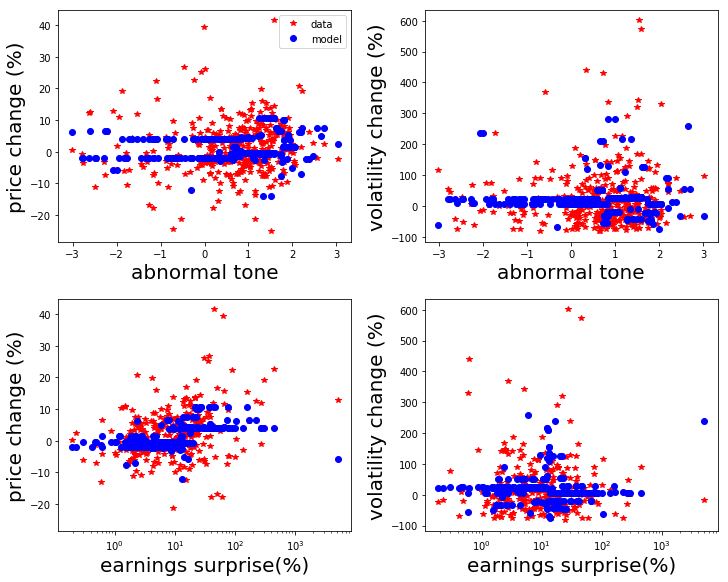

In [91]:
fig,axs = plt.subplots(2,2,figsize = (10,8),constrained_layout=True)
#fig.suptitle('stock change around earnings call VS prediction',fontsize = 20)
axs[0,0].plot(X['tone_ab'],y['price_change']*100,'r*')
axs[0,0].plot(X['tone_ab'],y_pred[:,0]*100,'bo')
axs[0,0].tick_params('abnormal tone', colors='r')
axs[0,0].set_ylabel('price change (%)', color='k',fontsize = 20)
axs[0,0].set_xlabel('abnormal tone',fontsize = 20)
axs[0,0].legend(['data','model'])

axs[0,1].plot(X['tone_ab'],y['vola_change']*100,'r*')
axs[0,1].plot(X['tone_ab'],y_pred[:,1]*100,'bo')
axs[0,1].tick_params('abnormal tone', colors='r')
axs[0,1].set_ylabel('volatility change (%)', color='k',fontsize = 20)
axs[0,1].set_xlabel('abnormal tone',fontsize = 20)

axs[1,0].plot(X['eps'],y['price_change']*100,'r*')
axs[1,0].plot(X['eps'],y_pred[:,0]*100,'bo')
axs[1,0].set_xlabel('earnings surprise(%)',fontsize = 20)
axs[1,0].tick_params('earnings surprise', colors='r')
axs[1,0].set_ylabel('price change (%)', color='k',fontsize = 20)
axs[1,0].set_xscale('log')

axs[1,1].plot(X['eps'],y['vola_change']*100,'r*')
axs[1,1].plot(X['eps'],y_pred[:,1]*100,'bo')
axs[1,1].tick_params('earnings surprise', colors='r')
axs[1,1].set_ylabel('volatility change (%)', color='k',fontsize = 20)
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('earnings surprise(%)',fontsize = 20)

plt.show()    
fig.savefig('/Users/leonardo_da_cina/Desktop/stock_vs_model.png')